<a href="https://colab.research.google.com/github/iliya1984/DevML/blob/main/computer_vision/yale_face_recognition_LBPH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face recognition using Local Binary Pattern Histogram algorithm

## Importing python libraries

In [83]:
from PIL import Image
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive

import zipfile
import os
from os import path
import random
from sklearn.metrics import accuracy_score

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading and extracting images

In [84]:
zip_file_path = '/content/drive/MyDrive/Workspace/Computer Vision/datasets/yalefaces.zip'
extract_path = './content/datasets/yalefaces'
models_path = './content/models'
model_yml_path = models_path + '/lbph_classifier.yml'

In [85]:
zip_object = zipfile.ZipFile(file=zip_file_path, mode = 'r')
zip_object.extractall(extract_path)
zip_object.close()

## Defining helper classes

In [86]:
class FaceImages:
  def __init__(self):
    self.images = []

  def get_npimages(self):
    images = []
    for image in self.images:
      np_image = image.image
      images.append(np_image)
    return images

  def get_ids(self):
    ids = []
    for image in self.images:
      id = image.id
      ids.append(id)

    return np.array(ids)

class FaceImage:
  def __init__(self, id, image):
    self.id = id
    self.image = image
    self.prediction = None

def get_image_paths():
  image_paths = os.listdir(extract_path)
  invalid_paths = []
  for path in image_paths:
    if not ("subject" in path):
      print(f'Invalid path "{path}"')
      invalid_paths.append(path)

  for path in invalid_paths:
    image_paths.remove(path)
    print(f'Removed path "{path}"')

  return image_paths

def get_image_data():
  image_paths = get_image_paths()
  paths = [os.path.join(extract_path, f) for f in image_paths]
  #print(paths)

  images = FaceImages()
  for path in paths:
    #print(path)
    image = Image.open(path).convert('L')
    #print(type(image))
    image_np = np.array(image, 'uint8')
    #print(type(image_np))
    id = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
    #print(id)
    images.images.append(FaceImage(id, image_np))

  return images

## Spliting data set to train and test sets

In [87]:
faces = get_image_data()
random.shuffle(faces.images)

Invalid path "Readme.txt"
Invalid path "data"
Removed path "Readme.txt"
Removed path "data"


## Previewing sample image

In [88]:
sample_image = faces.get_npimages()[0]

In [89]:
sample_image

array([[124, 116, 102, ..., 255, 242, 246],
       [255, 251, 230, ..., 255, 246, 248],
       [246, 227, 231, ..., 255, 255, 255],
       ...,
       [243, 245, 255, ..., 231, 220, 216],
       [255, 255, 255, ..., 213, 206, 218],
       [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8)

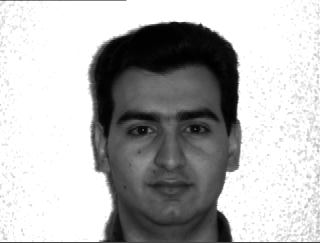

In [90]:
cv2_imshow(sample_image)

In [91]:
dataset_size = len(faces.images)
train_set = FaceImages()
test_set = FaceImages()

split_ratio = 0.75
split_threshold = int(split_ratio * dataset_size)

index = 0;
for face in faces.images:
  if index < split_threshold:
    train_set.images.append(face)
  else:
    test_set.images.append(face)

  index = index + 1

print(f'Splited faces dataset to a train set of the size {len(train_set.images)} and a test set of the size {len(test_set.images)}')


Splited faces dataset to a train set of the size 123 and a test set of the size 42


## Training Local Binary Pattern Histogram classifier

In [92]:
if path.exists(models_path) == False:
  os.mkdir(models_path)
  print(f'{models_path} directory was created')
else:
  print(f'{models_path} directory already exists')

./content/models directory already exists


In [93]:
#lbph_classifier = cv2.face.LBPHFaceRecognizer_create(radius = 4, neighbors=14, grid_x = 9, grid_y = 9)
lbph_classifier = cv2.face.LBPHFaceRecognizer_create(radius = 1, neighbors=3, grid_x = 2, grid_y = 2)

In [94]:
lbph_classifier.train(train_set.get_npimages(), train_set.get_ids())
lbph_classifier.write(model_yml_path)

## Sample test image prediction

In [95]:
lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_face_classifier.read(model_yml_path)

In [96]:
test_image = test_set.images[0]
prediction = lbph_face_classifier.predict(test_image.image)
prediction

(15, 0.04236472775884212)

In [97]:
test_image.id

9

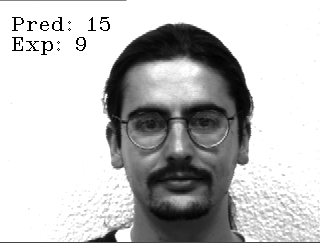

In [98]:
cv2.putText(test_image.image, 'Pred: ' + str(prediction[0]), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
cv2.putText(test_image.image, 'Exp: ' + str(test_image.id), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
cv2_imshow(test_image.image)

## Model evaluation

In [99]:
def eveluate_model(lbph_face_classifier, test_set):
  predictions = []
  labels = []

  for test_image in test_set.images:
    prediction, _ = lbph_face_classifier.predict(test_image.image)
    predictions.append(prediction)
    labels.append(test_image.id)

  predictions = np.array(predictions)
  labels = np.array(labels)

  return predictions, labels

In [100]:
predictions, labels = eveluate_model(lbph_face_classifier, test_set)
score = round(accuracy_score(labels, predictions), 4)
print(f'Accuracy score is {score}')

Accuracy score is 0.6429


## Hyperparameter tuning

In [101]:
class ParamName:
  ID = 'id'
  RADIUS = 'radius'
  NEIGHBORS = 'neighbors'
  GRID_X = 'grid_x'
  GRID_Y = 'grid_y'

param_list = []

param_bag = {}
param_bag[ParamName.ID] = 1
param_bag[ParamName.RADIUS] = 1
param_bag[ParamName.NEIGHBORS] = 3
param_bag[ParamName.GRID_X] = 2
param_bag[ParamName.GRID_Y] = 2
param_list.append(param_bag)

param_bag = {}
param_bag[ParamName.ID] = 2
param_bag[ParamName.RADIUS] = 2
param_bag[ParamName.NEIGHBORS] = 8
param_bag[ParamName.GRID_X] = 5
param_bag[ParamName.GRID_Y] = 5
param_list.append(param_bag)

param_bag = {}
param_bag[ParamName.ID] = 3
param_bag[ParamName.RADIUS] = 4
param_bag[ParamName.NEIGHBORS] = 14
param_bag[ParamName.GRID_X] = 9
param_bag[ParamName.GRID_Y] = 9
param_list.append(param_bag)

In [102]:
result_list = []

for p in param_list:
  model_file_path = models_path + f'/lbph_classifier_{p[ParamName.ID]}.yml'
  lbph_classifier = cv2.face.LBPHFaceRecognizer_create(radius = p[ParamName.RADIUS], neighbors=p[ParamName.NEIGHBORS], grid_x = p[ParamName.GRID_X], grid_y = p[ParamName.GRID_Y])
  lbph_classifier.train(train_set.get_npimages(), train_set.get_ids())
  lbph_classifier.write(model_file_path)

  lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
  lbph_face_classifier.read(model_file_path)

  predictions, labels = eveluate_model(lbph_face_classifier, test_set)
  score = round(accuracy_score(labels, predictions), 4)

  result = {}
  result['parameters'] = p
  result['score'] = score
  result_list.append(result)

  print(f'Parameters for id={p[ParamName.ID]} were applied. Accuracy score={score*100}%')

Parameters for id=1 were applied. Accuracy score=64.29%
Parameters for id=2 were applied. Accuracy score=76.19%
Parameters for id=3 were applied. Accuracy score=83.33%


In [114]:
def print_parameters(parameters):
  print(f'Configuration Id={parameters[ParamName.ID]}')
  print(f'Radius={parameters[ParamName.RADIUS]}')
  print(f'Neighbors={parameters[ParamName.NEIGHBORS]}')
  print(f'Grid X={parameters[ParamName.GRID_X]}')
  print(f'Grid Y={parameters[ParamName.GRID_Y]}')

def print_parameter_tuning_result(result):
  print_parameters(result['parameters'])
  score = result['score']
  print(f'Accuracy score={score*100}%')
  print('')

print('Printing hyperparameter tuning results:')
print('')

for result in result_list:
  print_parameter_tuning_result(result)

Printing hyperparameter tuning results:

Configuration Id=1
Radius=1
Neighbors=3
Grid X=2
Grid Y=2
Accuracy score=64.29%

Configuration Id=2
Radius=2
Neighbors=8
Grid X=5
Grid Y=5
Accuracy score=76.19%

Configuration Id=3
Radius=4
Neighbors=14
Grid X=9
Grid Y=9
Accuracy score=83.33%



In [113]:
best_result = None
best_score = 0
for r in result_list:
    score = r['score']
    if score > best_score:
      best_score = score
      best_result = r

print('Hyperparameter tuning best result:')
print('')
print_parameter_tuning_result(best_result)


Hyperparameter tuning best result:

Configuration Id=3
Radius=4
Neighbors=14
Grid X=9
Grid Y=9
Accuracy score=83.33%

